In [1]:
# install PyAudio http://people.csail.mit.edu/hubert/pyaudio/
# pip install pyaudio
import pyaudio
import wave
import sys

# default settings for record and playback
# fill be overriden!
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 22050
DURATION = None

In [2]:
import contextlib

wave_file = "peterpiper.wav"
wf = wave.open(wave_file, 'rb')
# byte representation ~ 200K bytes
data = wf.readframes(-1)

with contextlib.closing(wf) as f:
    FRAMES = f.getnframes()
    RATE = f.getframerate()
    CHANNELS = f.getnchannels()
    DURATION = FRAMES / float(RATE)
    print("Rate: {}, frames: {}, channels: {}, time: {}".format(RATE, FRAMES, CHANNELS, DURATION))

Rate: 24000, frames: 107700, channels: 1, time: 4.4875


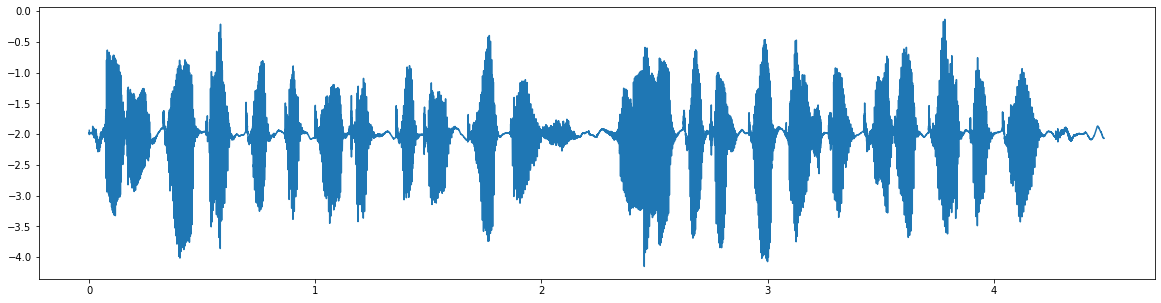

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# values as they are stored in int16 form, 2 bytes for measurement
signal = np.frombuffer(data, np.int16)

# time in seconds
time = [float(i) * DURATION / len(signal) for i in range(len(signal))]

# rescale to 0.1
norm_sig = [(x / 8192.) - 2 for x in signal]
plt.figure(figsize=(20, 5))
plt.plot(time, norm_sig)
plt.show()

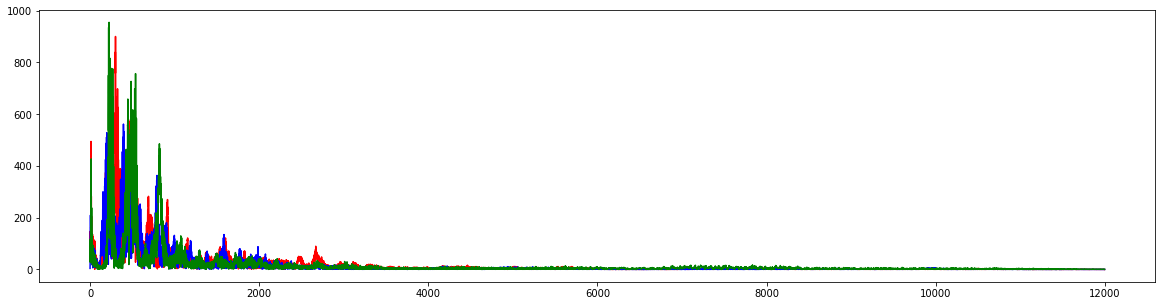

In [4]:
from scipy.fftpack import fft, ifft
from scipy.io import wavfile # get the api

# one second contains RATE values values

spectrums = []

for second in (0, 1, 2):
    complex_spectrum = fft(norm_sig[RATE * second:RATE * (second + 1)]) # calculate fourier transform for 1 sec. Values are complex
    # you only need half of the fft list (real signal symmetry)
    spectrum = abs(complex_spectrum[1:len(complex_spectrum) // 2])  # and only magnitude with no phase
    spectrums.append(spectrum)

plt.figure(figsize=(20, 5))
for second, color in ((0, 'r'), (1, 'b'), (2, 'g')):
    plt.plot(spectrums[second], color=color)
plt.show()

## Spectrum reduction ##
See [this answer](https://stackoverflow.com/a/27191172) to understand FFT to Hz ratio.

0.22284122562674097 1.4001527146918298


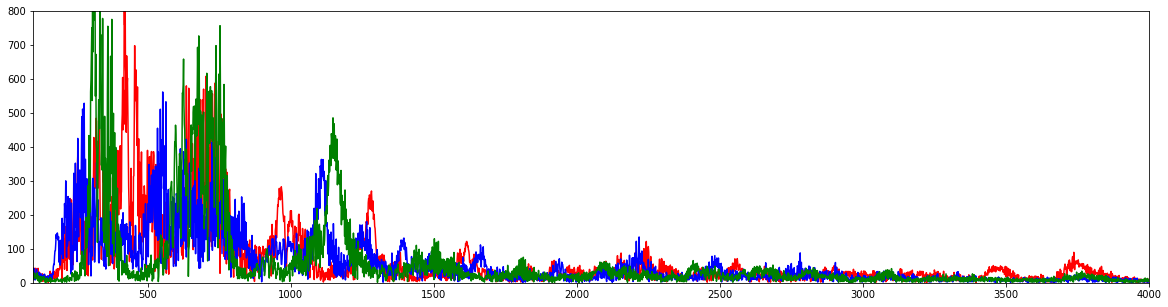

In [5]:
df = 1. / DURATION
dw = 2 * np.pi / DURATION
print(df, dw)
freqs = np.array([dw * n for n in range(RATE // 2 - 1)])
plt.figure(figsize=(20,5))
plt.ylim([0, 800])
plt.xlim([100, 4000])
for second, color in ((0, 'r'), (1, 'b'), (2, 'g')):
    plt.plot(freqs, spectrums[second], color=color)
plt.show()

[In telephony, the usable voice frequency band ranges from approximately 300 to 3400 Hz](https://en.wikipedia.org/wiki/Voice_frequency#Frequency_band). Let's remain only low freq.

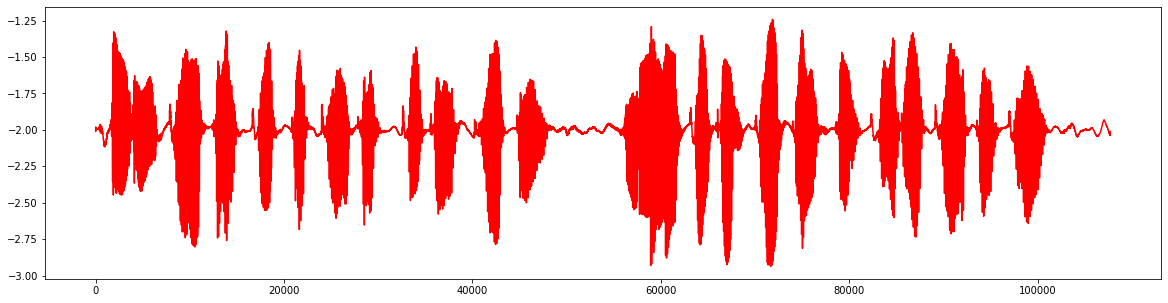

In [6]:
complex_spectrum = fft(norm_sig)
d = len(complex_spectrum) // 2 

end = int(7000 / dw)

# cut upper spectrum to inf.
complex_spectrum[end+1:d] = 0
complex_spectrum[d+end+1:] = 0
signal = np.real(ifft(complex_spectrum))

plt.figure(figsize=(20,5))
plt.plot(signal, color='r')
plt.show()

de_norm_sig = (signal + 2.) * 8192.
data = de_norm_sig.astype(np.int16).tostring()

# play this
p = pyaudio.PyAudio()
out_stream = p.open(format=FORMAT,
            channels=wf.getnchannels(),
            rate=wf.getframerate(),
            output=True,
    )
out_stream.write(data)
out_stream.stop_stream()
out_stream.close()
p.terminate()